# Platform Data Analysis

## Execution

### Import packages

In [1]:
# pip3 install mariadb
# pip3 install pandas
# pip3 install numpy  
# sudo apt-get install libatlas-base-dev
# pip3 install matplotlib
# pip3 install ipympl
# pip3 install ipywidgets

%matplotlib widget
%config InlineBackend.figure_format = 'png'

import os
import numpy as np
import pandas as pd

from ipywidgets import interact, interactive, interactive_output, fixed, interact_manual, IntSlider, IntRangeSlider, HBox
import ipywidgets as widgets

### Data Visualization 

In [2]:
from utility import db_conn, plot
import config

username = os.environ.get("db_user")
password = os.environ.get("db_pwd")

db_name_button = widgets.RadioButtons(
        options=['Reformer_BW', 'Reformer_SE'],
        description='Select Database:',
        disabled=False
        )

config.db_name = db_name_button.value
config.cur = db_conn(username=username, password=password, db_name=config.db_name)
config.cur.execute('SHOW tables')

table_dropdown = widgets.Dropdown(options=[u for i in config.cur.fetchall()[:] for u in i][::-1], description='Table')

config.cur.execute(f"SELECT * FROM {table_dropdown.value}")
config.cur.fetchall()

time_slider = widgets.IntRangeSlider(value=[0, config.cur.rowcount], max=config.cur.rowcount, step=1200, description='Time Span', continuous_update=False)
checkbox = widgets.Checkbox(value=False, description='Steady-State Only', disabled=False, indent=False)
toggle_calc = widgets.ToggleButton(value=False, description='Only Calc', disabled=False, button_style='success', tooltip='Description',icon='check')
toggle_plot = widgets.ToggleButton(value=False, description='Plot it!', disabled=False, button_style='info', tooltip='Description',icon='check')


alter_db = False
def update_db_name(change):
    global alter_db
    alter_db = True
    config.db_name = change.new
    config.cur = db_conn(username=username, password=password, db_name=config.db_name)
    config.cur.execute('SHOW tables')
    table_dropdown.options = [u for i in config.cur.fetchall()[:] for u in i][::-1]
    config.cur.execute(f"SELECT * FROM {table_dropdown.value}")
    config.cur.fetchall()
    columns_button.options = [col[0] for col in config.cur.description]
    time_slider.max = config.cur.rowcount
    time_slider.value = [0, time_slider.max]
db_name_button.observe(update_db_name, 'value')    


def update_range(*args):
    global alter_db
    if not alter_db:
        config.cur.execute(f"SELECT * FROM {table_dropdown.value}")
        config.cur.fetchall()
        time_slider.max = config.cur.rowcount
        time_slider.value = [0, time_slider.max]
        columns_button.options = [col[0] for col in config.cur.description]
        print('change time', time_slider.value)
        print('change time', time_slider.max)
        #TC_selector.options = [i[0] for i in cur.description if re.search("^TC|^EVA", i[0])]
    else:
        alter_db = False
table_dropdown.observe(update_range, 'value')


plot = interactive_output(plot, {'Table_name':table_dropdown, 'Time':time_slider, 'SS':checkbox, 'Calc': toggle_calc, 'Ploting':toggle_plot})
toggle = HBox([toggle_calc, toggle_plot])
control = HBox([table_dropdown, time_slider, checkbox,])
#selector = HBox([TC_selector])
widgets.VBox([db_name_button, toggle, control, plot])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
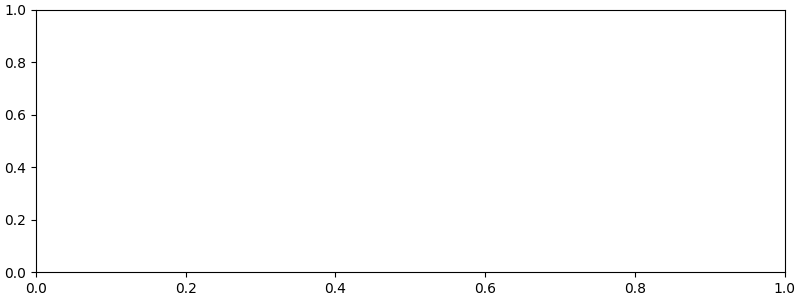

In [3]:
from utility import plot_cols
import matplotlib.pyplot as plt

fig_col, ax_col = plt.subplots(1, constrained_layout=True, figsize=(8,3), sharex=False)
fig_col.canvas.toolbar_position = 'left'
    
config.cur.execute(f"SELECT * FROM {table_dropdown.value}")
columns_button = widgets.SelectMultiple(options=[col[0] for col in config.cur.description], description='Select Cols', disabled=False, continuous_update=False)

def update_col_names(change) -> str:
    string = ""
    for i in change.new:
        string = string + i + ','
    plot_cols(col_string=string[:-1], table_name=table_dropdown.value, ax=ax_col)
columns_button.observe(update_col_names, 'value')   

widgets.VBox([columns_button])

### Close Remote Connection 

In [4]:
conn.close()

NameError: name 'conn' is not defined

## Summary

import markdown
markdown.markdown('#Hi')
#### 實驗結果 
- 圖中有兩個穩定點(Steady-State), 分別為 ***半載(51A)*** 和 ***全載(85A)*** 的操作條件
    - 半載穩定時間區間:
        - **7680-8580s (約15分)**
    - 全載穩定時間區間: 
        - **9720-11340s (約27分)**
- 兩個穩定點的平均觸媒床溫度(TC10)，均在參考溫度附近:
    - 半載均溫: **317.28oC**, 參考溫度: **315oC**
    - 半載均溫: **333.22oC**, 參考溫度: **332oC**
- 燃料蒸氣的進料溫度(EVA_Out) 約落在**200-200oC**
- 平均燃料液體進料流率(Weight_Rate):
    - 半載: **49.54 [g/min]**, 參考: **49.02 [g/min]**
    - 半載: **81.75 [g/min]**, 參考: **81.45 [g/min]**
- 此次實驗，燃燒室的燃料全程使用純氫進料(未採用回燒管路)，流率分別為:
    - 半載: **9.5 [LPM]**
    - 半載: **12.5 [LPM]**
- 重組次單元的熱效率(Enyhalpy Efficiency)分別為:
    - 半載: **94.45 %**
    - 半載: **93.59 %**

#### 與車測中心比較
- 重組次單元的熱效率(Enyhalpy Efficiency)分別為:
    - 半載: **88.1 %** (此次實驗: **94.45 %**)
    - 半載: **97.9 %** (此次實驗: **93.59 %**)
1. 車測中心使用的氣體燃料，為氦氫氣燃料量(30/70%):
    - 半載: **22.6 LPM**, 約為**15.7 LPM-H2** (此次實驗: **9.5 [LPM-H2]**)
    - 半載: **30 LPM**, 約為**20.9 LPM-H2** (此次實驗: **12.5 [LPM-H2]**)
2. 車測中心的燃料蒸氣的進料溫度(EVA_Out) 約落在**240-260oC** (此次實驗約落在**200-200oC**)
3. 兩次量測均未考慮環境的熱逸散